In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive/MyDrive/SaltIdentification/

/content/drive/MyDrive/SaltIdentification


### Importing the Libraries

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from tqdm.auto import tqdm, trange
from itertools import chain

import cv2
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import models, Input, layers, callbacks, utils, optimizers
import random,os, sys
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

from sklearn.metrics import confusion_matrix


### Setting-up configuration for the Images

In [5]:
class config:
    im_width = 128
    im_height = 128
    im_chan = 3
    path_train = 'train/'
    path_test = 'test/'

### Reading the Images

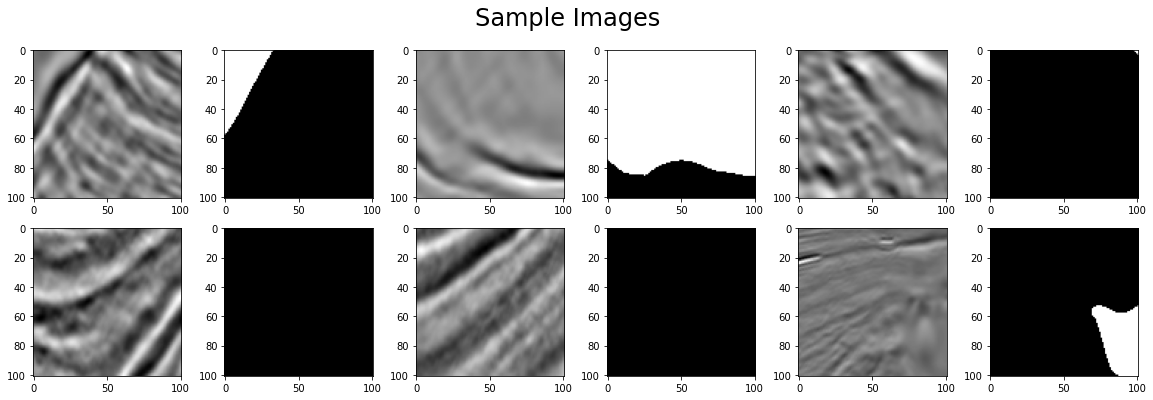

In [6]:
random.seed(19)
ids = random.choices(os.listdir('train/images'), k=6)
fig = plt.figure(figsize=(20,6))
for j, img_name in enumerate(ids):
    q = j+1
    
    img = load_img('train/images/' + img_name)
    img_mask = load_img('train/masks/' + img_name)
    
    plt.subplot(2, 6, q*2-1)
    plt.imshow(img)
    plt.subplot(2, 6, q*2)
    plt.imshow(img_mask)
fig.suptitle('Sample Images', fontsize=24);

In [7]:
train_ids = next(os.walk(config.path_train+"images"))[2]
#test_ids = next(os.walk(config.path_test+"images"))[2]

In [8]:
X = np.zeros((len(train_ids), config.im_height, config.im_width, config.im_chan), dtype=np.uint8)
Y = np.zeros((len(train_ids), config.im_height, config.im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    x = img_to_array(load_img(config.path_train + '/images/' + id_, color_mode="grayscale"))
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X[n] = x
    mask = img_to_array(load_img(config.path_train + '/masks/' + id_, color_mode="grayscale"))
    Y[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')
print('X shape:', X.shape)
print('Y shape:', Y.shape)

Getting and resizing train images and masks ... 



Done!
X shape: (4000, 128, 128, 3)
Y shape: (4000, 128, 128, 1)


### Data Augmentation

In [9]:
X_train = X[:int(0.9*len(X))]
Y_train = Y[:int(0.9*len(X))]
X_eval  = X[int(0.9*len(X)):]
Y_eval  = Y[int(0.9*len(X)):]

X_train = np.append(X_train, [np.fliplr(x) for x in X], axis=0)
Y_train = np.append(Y_train, [np.fliplr(x) for x in Y], axis=0)
X_train = np.append(X_train, [np.flipud(x) for x in X], axis=0)
Y_train = np.append(Y_train, [np.flipud(x) for x in Y], axis=0)
# X_train = np.append(X_train, [np.rot90(x, k=1) for x in X], axis=0)
# Y_train = np.append(Y_train, [np.rot90(x, k=1) for x in Y], axis=0)
# X_train = np.append(X_train, [np.rot90(x, k=3) for x in X], axis=0)
# Y_train = np.append(Y_train, [np.rot90(x, k=3) for x in Y], axis=0)

del X, Y

print('X train shape:', X_train.shape, 'X eval shape:', X_eval.shape)
print('Y train shape:', Y_train.shape, 'Y eval shape:', Y_eval.shape)

X train shape: (11600, 128, 128, 3) X eval shape: (400, 128, 128, 3)
Y train shape: (11600, 128, 128, 1) Y eval shape: (400, 128, 128, 1)


In [10]:
Y_eval=np.where(Y_eval==False, 0, Y_eval)
Y_train=np.where(Y_train==False, 0, Y_train)

### Normalizing the Images

In [11]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  #input_mask -= 1
  return input_image, input_mask

### Creating Batches of Data

In [12]:
@tf.function
def load_image_train(X_train,Y_train):
  input_image = tf.image.resize(X_train, (128, 128))
  input_mask = tf.image.resize(Y_train, (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [13]:
TRAIN_LENGTH = len(X_train)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [14]:
def load_image_test(X_train,Y_train):
  input_image = tf.image.resize(X_train, (128, 128))
  input_mask = tf.image.resize(Y_train, (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [15]:
X_train=tf.convert_to_tensor(
    X_train, dtype=tf.float32, dtype_hint=None, name=None
)

X_eval=tf.convert_to_tensor(
    X_eval, dtype=tf.float32, dtype_hint=None, name=None
)

Y_train=tf.convert_to_tensor(
    Y_train, dtype=tf.int8, dtype_hint=None, name=None
)

Y_eval=tf.convert_to_tensor(
    Y_eval, dtype=tf.int8, dtype_hint=None, name=None
)

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,Y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_eval,Y_eval))

In [17]:
train = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_dataset.map(load_image_test)

In [18]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

### Function to display the Image and corresponding Mask

In [19]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

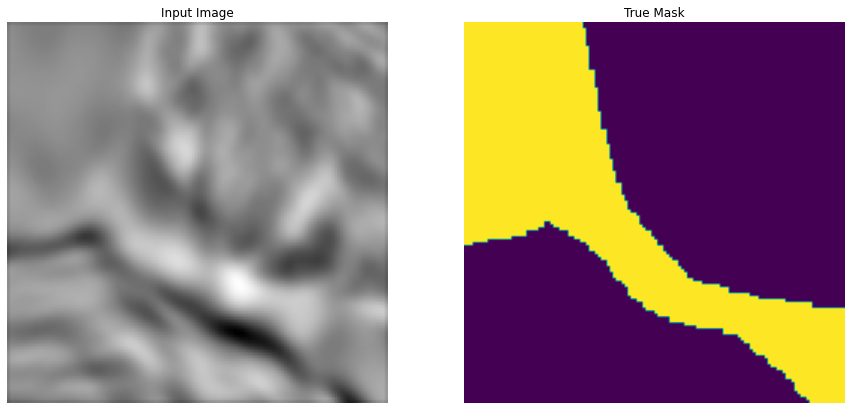

In [20]:
for image, mask in train.take(6):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [21]:
from tensorflow import keras
img_size=(128,128)
num_classes=2
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [22]:
OUTPUT_CHANNELS = 2

In [23]:
model = get_model(img_size,num_classes)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [25]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
   display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

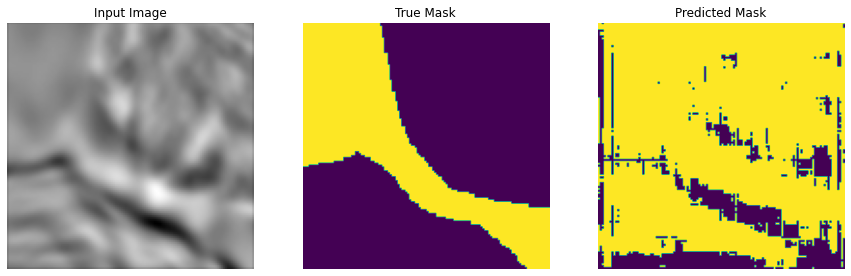

In [26]:
show_predictions()

### Callback function to display the intermediate results:

In [27]:
iou_history=[]
epoch_history=[]
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if(epoch%5 ==0):
      #clear_output(wait=True)
      show_predictions()
      print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
      tn, fp, fn, tp=confusion_matrix(Y_eval.numpy().flatten(),np.expand_dims(np.argmax(model.predict(X_eval, verbose=1),axis=-1),axis=-1).flatten()).ravel()
      IOU=tp/(tp+fp+fn)
      iou_history.append(IOU)
      epoch_history.append(epoch)
      print('IOU Score after epoch'+ str(epoch)+" is "+ str(IOU))




### Training the model

Epoch 1/200
181/181 [==============================] - 47s 239ms/step - loss: 0.6780 - accuracy: 0.8169 - val_loss: 0.8943 - val_accuracy: 0.2443


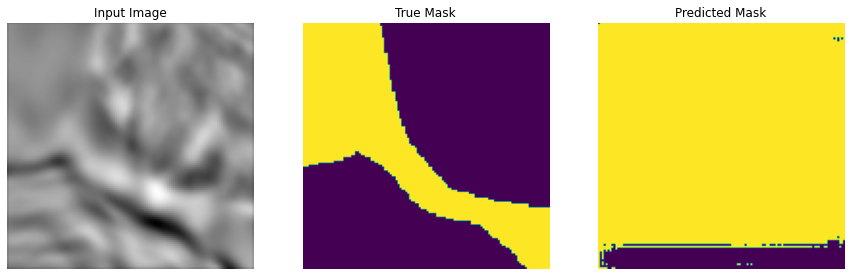


Sample Prediction after epoch 1

13/13 [==============================] - 1s 51ms/step
IOU Score after epoch0 is 0.23838080456779956
Epoch 2/200
181/181 [==============================] - 43s 238ms/step - loss: 0.2964 - accuracy: 0.8863 - val_loss: 1.2905 - val_accuracy: 0.1966
Epoch 3/200
181/181 [==============================] - 43s 236ms/step - loss: 0.2561 - accuracy: 0.8995 - val_loss: 0.4339 - val_accuracy: 0.7772
Epoch 4/200
181/181 [==============================] - 43s 237ms/step - loss: 0.2234 - accuracy: 0.9139 - val_loss: 0.2383 - val_accuracy: 0.9035
Epoch 5/200
181/181 [==============================] - 43s 237ms/step - loss: 0.2095 - accuracy: 0.9203 - val_loss: 0.2321 - val_accuracy: 0.9130
Epoch 6/200
181/181 [==============================] - 43s 237ms/step - loss: 0.1950 - accuracy: 0.9253 - val_loss: 0.2153 - val_accuracy: 0.9123


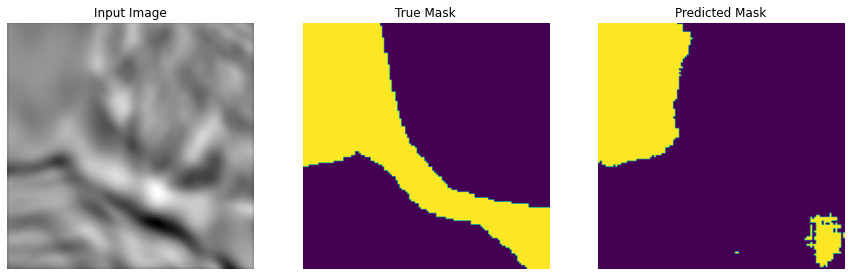


Sample Prediction after epoch 6

13/13 [==============================] - 0s 30ms/step
IOU Score after epoch5 is 0.012410162221360287
Epoch 7/200
181/181 [==============================] - 43s 240ms/step - loss: 0.1896 - accuracy: 0.9266 - val_loss: 0.3309 - val_accuracy: 0.8606
Epoch 8/200
181/181 [==============================] - 43s 235ms/step - loss: 0.1851 - accuracy: 0.9283 - val_loss: 0.1986 - val_accuracy: 0.9100
Epoch 9/200
181/181 [==============================] - 43s 238ms/step - loss: 0.1676 - accuracy: 0.9347 - val_loss: 0.3098 - val_accuracy: 0.9019
Epoch 10/200
181/181 [==============================] - 43s 237ms/step - loss: 0.1670 - accuracy: 0.9361 - val_loss: 0.1992 - val_accuracy: 0.9267
Epoch 11/200
181/181 [==============================] - 43s 237ms/step - loss: 0.1654 - accuracy: 0.9361 - val_loss: 0.3403 - val_accuracy: 0.8690


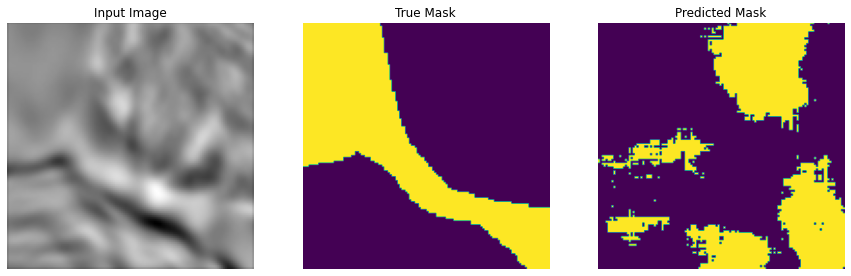


Sample Prediction after epoch 11

13/13 [==============================] - 0s 29ms/step
IOU Score after epoch10 is 0.024755865847730988
Epoch 12/200
181/181 [==============================] - 44s 241ms/step - loss: 0.1572 - accuracy: 0.9390 - val_loss: 0.1939 - val_accuracy: 0.9174
Epoch 13/200
181/181 [==============================] - 43s 237ms/step - loss: 0.1598 - accuracy: 0.9377 - val_loss: 0.2101 - val_accuracy: 0.9186
Epoch 14/200
181/181 [==============================] - 43s 237ms/step - loss: 0.1523 - accuracy: 0.9411 - val_loss: 0.1760 - val_accuracy: 0.9215
Epoch 15/200
181/181 [==============================] - 43s 237ms/step - loss: 0.1486 - accuracy: 0.9413 - val_loss: 0.2013 - val_accuracy: 0.9252
Epoch 16/200
181/181 [==============================] - 43s 237ms/step - loss: 0.1389 - accuracy: 0.9460 - val_loss: 0.1701 - val_accuracy: 0.9292


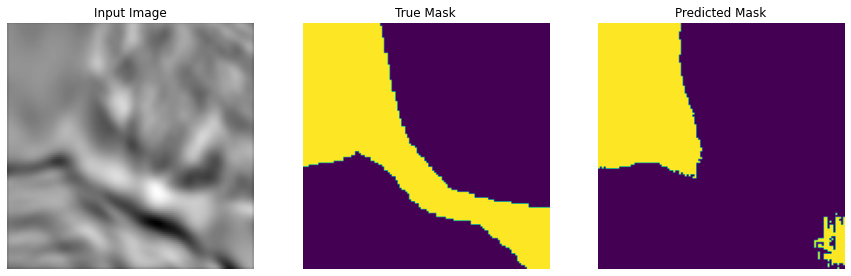


Sample Prediction after epoch 16

13/13 [==============================] - 0s 29ms/step
IOU Score after epoch15 is 0.02288457291006558
Epoch 17/200
181/181 [==============================] - 43s 240ms/step - loss: 0.1334 - accuracy: 0.9486 - val_loss: 0.1764 - val_accuracy: 0.9288
Epoch 18/200
181/181 [==============================] - 43s 236ms/step - loss: 0.1388 - accuracy: 0.9447 - val_loss: 0.1938 - val_accuracy: 0.9219
Epoch 19/200
181/181 [==============================] - 43s 237ms/step - loss: 0.1340 - accuracy: 0.9475 - val_loss: 0.2218 - val_accuracy: 0.9090
Epoch 20/200
181/181 [==============================] - 43s 236ms/step - loss: 0.1324 - accuracy: 0.9482 - val_loss: 0.1673 - val_accuracy: 0.9270
Epoch 21/200
181/181 [==============================] - 43s 238ms/step - loss: 0.1204 - accuracy: 0.9530 - val_loss: 0.1937 - val_accuracy: 0.9214


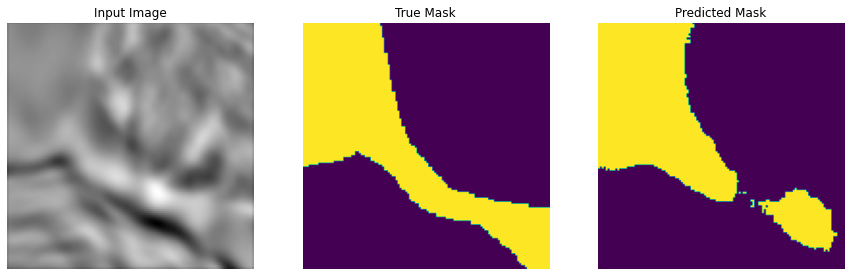


Sample Prediction after epoch 21

13/13 [==============================] - 0s 29ms/step
IOU Score after epoch20 is 0.015106881184379485
Epoch 22/200
181/181 [==============================] - 44s 241ms/step - loss: 0.1257 - accuracy: 0.9511 - val_loss: 0.1489 - val_accuracy: 0.9383
Epoch 23/200
181/181 [==============================] - 43s 238ms/step - loss: 0.1179 - accuracy: 0.9550 - val_loss: 0.1803 - val_accuracy: 0.9279
Epoch 24/200
181/181 [==============================] - 43s 239ms/step - loss: 0.1115 - accuracy: 0.9570 - val_loss: 0.1714 - val_accuracy: 0.9233
Epoch 25/200
181/181 [==============================] - 43s 239ms/step - loss: 0.1093 - accuracy: 0.9582 - val_loss: 0.1713 - val_accuracy: 0.9318
Epoch 26/200
181/181 [==============================] - 43s 239ms/step - loss: 0.1075 - accuracy: 0.9594 - val_loss: 0.2892 - val_accuracy: 0.9140


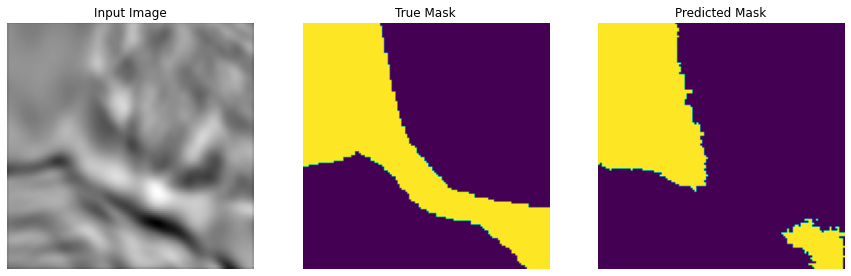


Sample Prediction after epoch 26

13/13 [==============================] - 0s 29ms/step
IOU Score after epoch25 is 0.0018116556842239714
Epoch 27/200
181/181 [==============================] - 44s 243ms/step - loss: 0.1068 - accuracy: 0.9588 - val_loss: 0.1866 - val_accuracy: 0.9320

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 28/200
181/181 [==============================] - 43s 238ms/step - loss: 0.0845 - accuracy: 0.9685 - val_loss: 0.1551 - val_accuracy: 0.9461
Epoch 29/200
181/181 [==============================] - 44s 241ms/step - loss: 0.0730 - accuracy: 0.9727 - val_loss: 0.1588 - val_accuracy: 0.9483
Epoch 30/200
181/181 [==============================] - 43s 239ms/step - loss: 0.0637 - accuracy: 0.9766 - val_loss: 0.1633 - val_accuracy: 0.9487
Epoch 31/200
181/181 [==============================] - 43s 240ms/step - loss: 0.0636 - accuracy: 0.9763 - val_loss: 0.1714 - val_accuracy: 0.9486


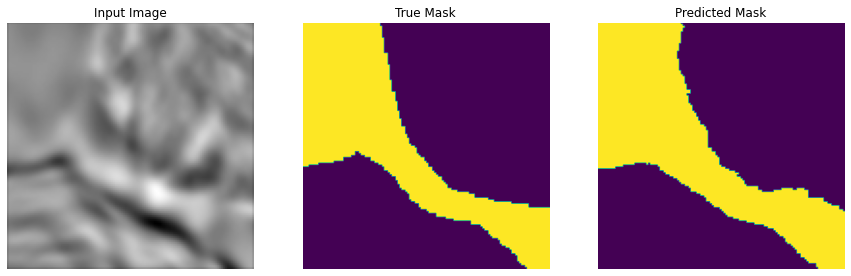


Sample Prediction after epoch 31

13/13 [==============================] - 0s 29ms/step
IOU Score after epoch30 is 0.004416612549092371
Epoch 32/200
181/181 [==============================] - 44s 242ms/step - loss: 0.0606 - accuracy: 0.9774 - val_loss: 0.1669 - val_accuracy: 0.9487

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 33/200
181/181 [==============================] - 43s 238ms/step - loss: 0.0589 - accuracy: 0.9778 - val_loss: 0.1633 - val_accuracy: 0.9510
Epoch 34/200
181/181 [==============================] - 43s 240ms/step - loss: 0.0577 - accuracy: 0.9785 - val_loss: 0.1652 - val_accuracy: 0.9506
Epoch 35/200
181/181 [==============================] - 43s 239ms/step - loss: 0.0571 - accuracy: 0.9787 - val_loss: 0.1668 - val_accuracy: 0.9503
Epoch 36/200
181/181 [==============================] - 43s 239ms/step - loss: 0.0565 - accuracy: 0.9793 - val_loss: 0.1701 - val_accuracy: 0.9503


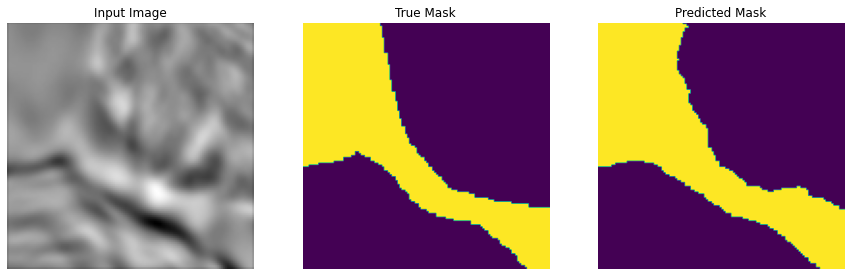


Sample Prediction after epoch 36

13/13 [==============================] - 0s 29ms/step
IOU Score after epoch35 is 0.007205206326697371
Epoch 37/200
181/181 [==============================] - 44s 242ms/step - loss: 0.0567 - accuracy: 0.9790 - val_loss: 0.1720 - val_accuracy: 0.9502

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 38/200
181/181 [==============================] - 43s 238ms/step - loss: 0.0568 - accuracy: 0.9788 - val_loss: 0.1705 - val_accuracy: 0.9502
Epoch 39/200
181/181 [==============================] - 43s 240ms/step - loss: 0.0581 - accuracy: 0.9783 - val_loss: 0.1696 - val_accuracy: 0.9502
Epoch 40/200
181/181 [==============================] - 43s 239ms/step - loss: 0.0565 - accuracy: 0.9788 - val_loss: 0.1695 - val_accuracy: 0.9504
Epoch 41/200
181/181 [==============================] - 43s 239ms/step - loss: 0.0574 - accuracy: 0.9784 - val_loss: 0.1697 - val_accuracy: 0.9503


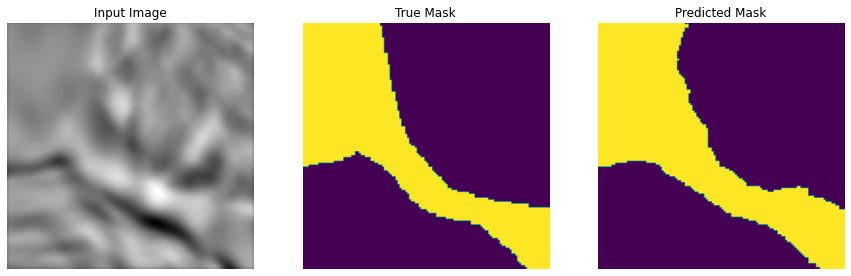


Sample Prediction after epoch 41

13/13 [==============================] - 0s 29ms/step
IOU Score after epoch40 is 0.007202354663462875
Epoch 42/200
181/181 [==============================] - 44s 242ms/step - loss: 0.0567 - accuracy: 0.9787 - val_loss: 0.1695 - val_accuracy: 0.9503

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 43/200
181/181 [==============================] - 43s 237ms/step - loss: 0.0554 - accuracy: 0.9793 - val_loss: 0.1694 - val_accuracy: 0.9504
Epoch 44/200
181/181 [==============================] - 43s 240ms/step - loss: 0.0553 - accuracy: 0.9794 - val_loss: 0.1692 - val_accuracy: 0.9503
Epoch 45/200
181/181 [==============================] - 43s 238ms/step - loss: 0.0581 - accuracy: 0.9785 - val_loss: 0.1694 - val_accuracy: 0.9503
Epoch 46/200
181/181 [==============================] - 43s 239ms/step - loss: 0.0563 - accuracy: 0.9789 - val_loss: 0.1693 - val_accuracy: 0.9503


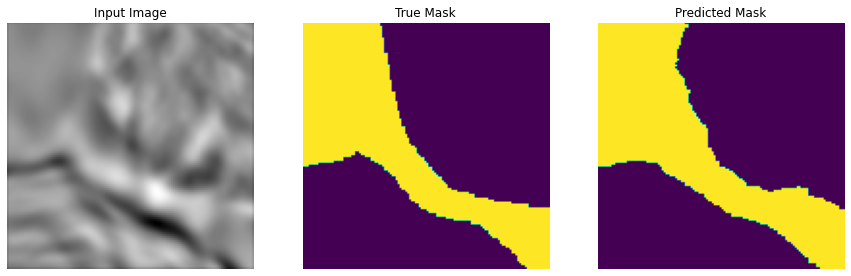


Sample Prediction after epoch 46

13/13 [==============================] - 0s 29ms/step
IOU Score after epoch45 is 0.007023294431032225
Epoch 47/200
181/181 [==============================] - 44s 242ms/step - loss: 0.0558 - accuracy: 0.9794 - val_loss: 0.1697 - val_accuracy: 0.9504

Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 48/200
181/181 [==============================] - 43s 239ms/step - loss: 0.0573 - accuracy: 0.9785 - val_loss: 0.1694 - val_accuracy: 0.9503
Epoch 49/200
181/181 [==============================] - 43s 239ms/step - loss: 0.0578 - accuracy: 0.9784 - val_loss: 0.1695 - val_accuracy: 0.9503
Epoch 50/200
181/181 [==============================] - 43s 240ms/step - loss: 0.0570 - accuracy: 0.9786 - val_loss: 0.1695 - val_accuracy: 0.9504
Epoch 51/200
181/181 [==============================] - 43s 239ms/step - loss: 0.0560 - accuracy: 0.9792 - val_loss: 0.1691 - val_accuracy: 0.9504


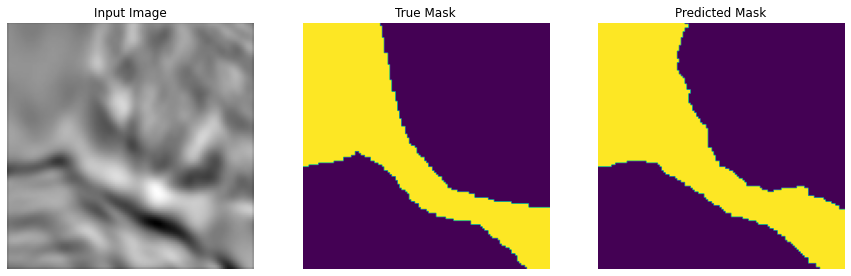


Sample Prediction after epoch 51

13/13 [==============================] - 0s 29ms/step
IOU Score after epoch50 is 0.0071292109256917814
Epoch 52/200
181/181 [==============================] - 44s 242ms/step - loss: 0.0580 - accuracy: 0.9782 - val_loss: 0.1694 - val_accuracy: 0.9503
Restoring model weights from the end of the best epoch.

Epoch 00052: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 00052: early stopping


In [28]:
EPOCHS = 200
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(X_eval)//BATCH_SIZE//VAL_SUBSPLITS

es = callbacks.EarlyStopping(patience=30, verbose=1, restore_best_weights=True)

rlp = callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-12, verbose=1)

save_model_weights = [
    tf.keras.callbacks.ModelCheckpoint("Salt_Identification.h5", save_best_only=True)
]


model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), es, rlp, save_model_weights])

In [29]:
def seg_metrics(y_true, y_pred, metric_name,
    metric_type='standard', drop_last = True, mean_per_class=False, verbose=False):
    """
    Compute mean metrics of two segmentation masks, via Keras.

    IoU(A,B) = |A & B| / (| A U B|)
    Dice(A,B) = 2*|A & B| / (|A| + |B|)

    Args:
        y_true: true masks, one-hot encoded.
        y_pred: predicted masks, either softmax outputs, or one-hot encoded.
        metric_name: metric to be computed, either 'iou' or 'dice'.
        metric_type: one of 'standard' (default), 'soft', 'naive'.
          In the standard version, y_pred is one-hot encoded and the mean
          is taken only over classes that are present (in y_true or y_pred).
          The 'soft' version of the metrics are computed without one-hot
          encoding y_pred.
          The 'naive' version return mean metrics where absent classes contribute
          to the class mean as 1.0 (instead of being dropped from the mean).
        drop_last = True: boolean flag to drop last class (usually reserved
          for background class in semantic segmentation)
        mean_per_class = False: return mean along batch axis for each class.
        verbose = False: print intermediate results such as intersection, union
          (as number of pixels).
    Returns:
        IoU/Dice of y_true and y_pred, as a float, unless mean_per_class == True
          in which case it returns the per-class metric, averaged over the batch.

    Inputs are B*W*H*N tensors, with
        B = batch size,
        W = width,
        H = height,
        N = number of classes
    """

    flag_soft = (metric_type == 'soft')
    flag_naive_mean = (metric_type == 'naive')

    # always assume one or more classes
    num_classes = K.shape(y_true)[-1]

    if not flag_soft:
        # get one-hot encoded masks from y_pred (true masks should already be one-hot)
        y_pred = K.one_hot(K.argmax(y_pred), num_classes)
        y_true = K.one_hot(K.argmax(y_true), num_classes)

    # if already one-hot, could have skipped above command
    # keras uses float32 instead of float64, would give error down (but numpy arrays or keras.to_categorical gives float64)
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    # intersection and union shapes are batch_size * n_classes (values = area in pixels)
    axes = (1,2) # W,H axes of each image
    intersection = K.sum(K.abs(y_true * y_pred), axis=axes)
    mask_sum = K.sum(K.abs(y_true), axis=axes) + K.sum(K.abs(y_pred), axis=axes)
    union = mask_sum  - intersection # or, np.logical_or(y_pred, y_true) for one-hot

    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    dice = 2 * (intersection + smooth)/(mask_sum + smooth)

    metric = {'iou': iou, 'dice': dice}[metric_name]

    # define mask to be 0 when no pixels are present in either y_true or y_pred, 1 otherwise
    mask =  K.cast(K.not_equal(union, 0), 'float32')

    if drop_last:
        metric = metric[:,:-1]
        mask = mask[:,:-1]

    if verbose:
        print('intersection, union')
        print(K.eval(intersection), K.eval(union))
        print(K.eval(intersection/union))

    # return mean metrics: remaining axes are (batch, classes)
    if flag_naive_mean:
        return K.mean(metric)

    # take mean only over non-absent classes
    class_count = K.sum(mask, axis=0)
    non_zero = tf.greater(class_count, 0)
    non_zero_sum = tf.boolean_mask(K.sum(metric * mask, axis=0), non_zero)
    non_zero_count = tf.boolean_mask(class_count, non_zero)

    if verbose:
        print('Counts of inputs with class present, metrics for non-absent classes')
        print(K.eval(class_count), K.eval(non_zero_sum / non_zero_count))

    return K.mean(non_zero_sum / non_zero_count)

def mean_iou(y_true, y_pred, **kwargs):
    """
    Compute mean Intersection over Union of two segmentation masks, via Keras.

    Calls metrics_k(y_true, y_pred, metric_name='iou'), see there for allowed kwargs.
    """
    return seg_metrics(y_true, y_pred, metric_name='iou', **kwargs)

def mean_dice(y_true, y_pred, **kwargs):
    """
    Compute mean Dice coefficient of two segmentation masks, via Keras.

    Calls metrics_k(y_true, y_pred, metric_name='iou'), see there for allowed kwargs.
    """
    return seg_metrics(y_true, y_pred, metric_name='dice', **kwargs)

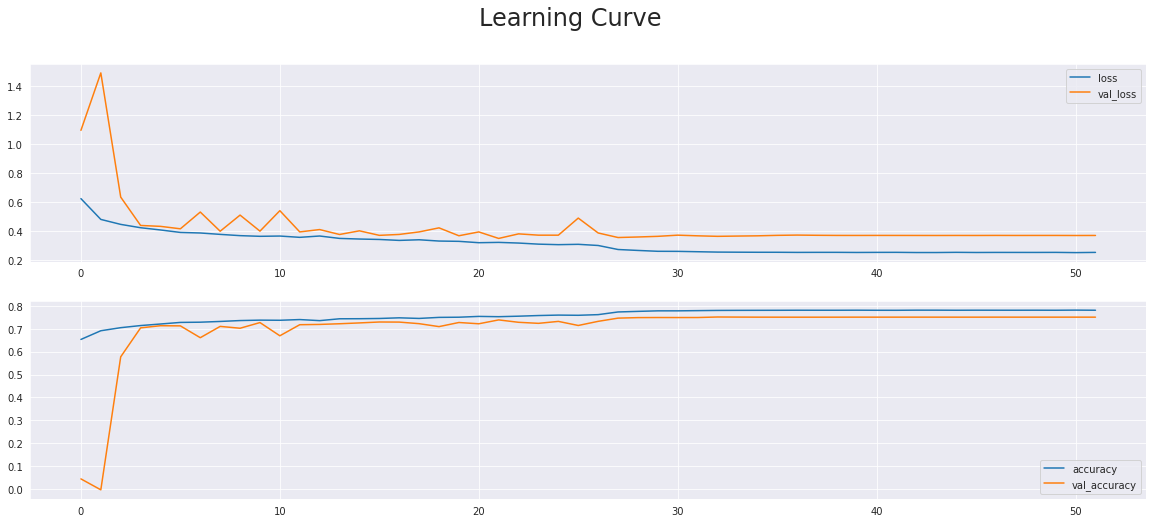

In [42]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
history = pd.DataFrame(model_history.history)
(history[['loss', 'val_loss']]+0.2).plot(ax=ax[0])
(history[['accuracy', 'val_accuracy']]-0.2).plot(ax=ax[1])
fig.suptitle('Learning Curve', fontsize=24);

In [31]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [32]:
# preds_eval = model.predict(X_eval, verbose=1)
# preds_eval= np.array(tf.argmax(preds_eval, axis=-1)[..., tf.newaxis])

# thresholds = np.linspace(0, 1, 50)
# ious = np.array([iou_metric_batch(np.array(Y_eval), np.int32(preds_eval > threshold)) for threshold in tqdm(thresholds)])

# threshold_best_index = np.argmax(ious[9:-10]) + 9
# iou_best = ious[threshold_best_index]
# threshold_best = thresholds[threshold_best_index]

# plt.plot(thresholds, ious)
# plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
# plt.xlabel("Threshold")
# plt.ylabel("IoU")
# plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
# plt.legend();

In [33]:
intersection=np.histogram2d(Y_eval.numpy().flatten(), np.expand_dims(np.argmax(model.predict(X_eval, verbose=1),axis=-1),axis=-1).flatten(), bins=(2, 2))[0]

13/13 [==============================] - 0s 30ms/step


In [34]:

labels = Y_eval.numpy()
y_pred = np.expand_dims(np.argmax(model.predict(X_eval, verbose=1),axis=-1),axis=-1)

true_objects = 2
pred_objects = 2
intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

# Compute areas (needed for finding the union between all objects)
area_true = np.histogram(labels, bins = true_objects)[0]
area_pred = np.histogram(y_pred, bins = pred_objects)[0]
area_true = np.expand_dims(area_true, -1)
area_pred = np.expand_dims(area_pred, 0)

# Compute union
union = area_true + area_pred - intersection

# Exclude background from the analysis
intersection = intersection[1:,1:]
union = union[1:,1:]
union[union == 0] = 1e-9

# Compute the intersection over union
iou = intersection / union  

13/13 [==============================] - 0s 30ms/step


Text(0.5, 1.0, 'IOU score on Validation Data')

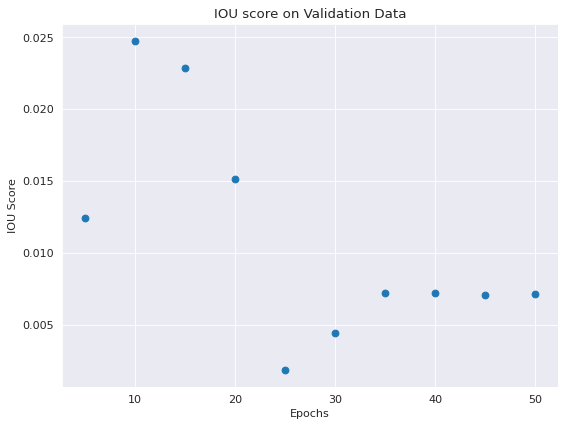

In [37]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(epoch_history[1:],np.array(iou_history)[1:]*1)
plt.xlabel('Epochs')
plt.ylabel('IOU Score')
plt.title('IOU score on Validation Data')